### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSBBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12152
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|     4|[80 CD 30 D5 80 C...|1990.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|     0|[E0 55 F0 56 00 0...|1991.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|     1|[A0 53 A0 53 80 C...|1992.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|    17|[80 D1 40 D6 00 C...|1993.0|SSSBSBBS|
|   2804.2| 38.4333|-119.3667|       TMAX|USS0019L17S|     1|[80 54 40 56 A0 5...|1994.0|SSSBSBBS|
+---------+--------+---------+-----------+-----------+------+-------------

### Get statistics summary from this dataset: (Added)

In [2]:
print "There are %d stations in this dataset"%df.groupby('station').count().count()

df_prcp = df.filter("measurement == 'PRCP'").groupby('station').count()
df_prcp.show()
print "%d stations contains PRCP data"%df_prcp.count()
print "Find the station with the maximum datapoints"
df_prcp.rdd.max(key=lambda x: x["count"])


There are 135 stations in this dataset
+-----------+-----+
|    station|count|
+-----------+-----+
|USC00268822|   38|
|USC00041985|   13|
|USC00267254|    2|
|US1CAED0007|    3|
|USC00049382|   10|
|USS0019L06S|   17|
|USC00263515|   48|
|USC00260765|    1|
|USC00264835|    2|
|USC00047689|   49|
|USC00041911|    1|
|USC00260770|    6|
|USC00262383|    2|
|USC00049105|   69|
|US1NVDG0004|    1|
|USC00260955|   34|
|USS0019L03S|   18|
|USC00269234|    2|
|USS0019L38S|    8|
|USC00260961|    7|
+-----------+-----+
only showing top 20 rows

111 stations contains PRCP data
Find the station with the maximum datapoints


Row(station=u'USC00265168', count=96)

### Select data for a particular station and measurement type

In [3]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00265168')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00265168'
96 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1391.7| 38.3844|-118.1056|       PRCP|USC00265168|     0|[00 00 00 00 00 0...|1898.0|SSSBSBBS|
|   1391.7| 38.3844|-118.1056|       PRCP|USC00265168|    30|[00 00 40 4E 00 0...|1899.0|SSSBSBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(96, 365)

### Script for plotting yearly plots

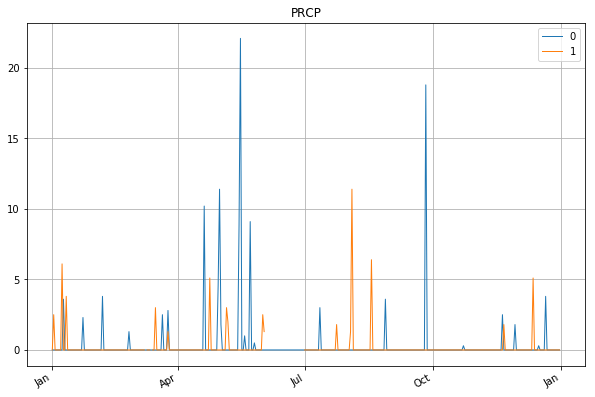

In [4]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [5]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/home/umyta/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


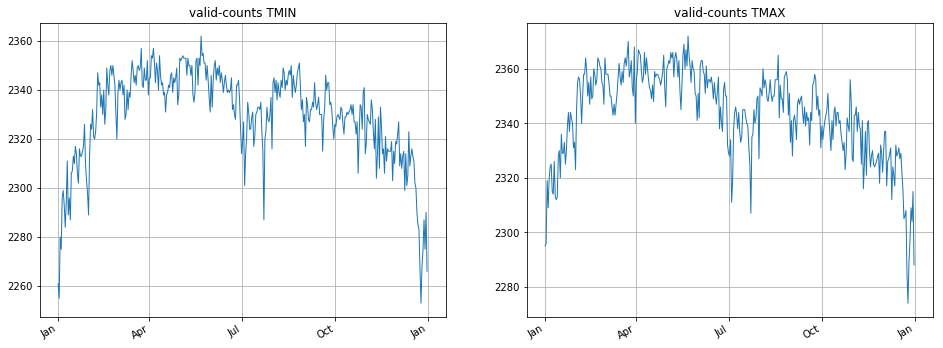

In [6]:
plot_pair(['TMIN','TMAX'],plot_valid)

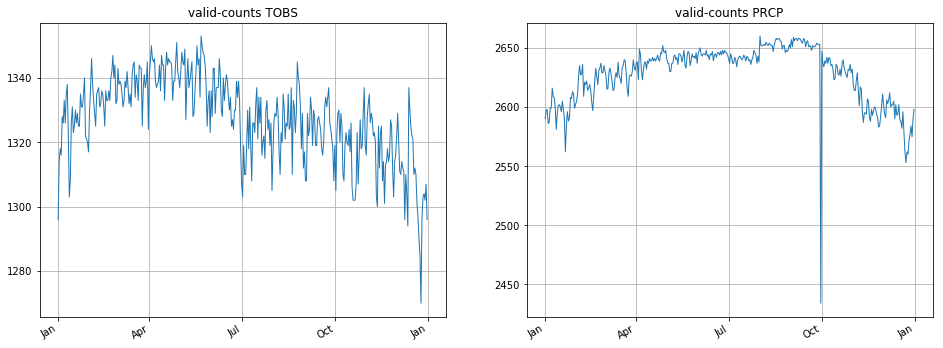

In [7]:
plot_pair(['TOBS','PRCP'],plot_valid)

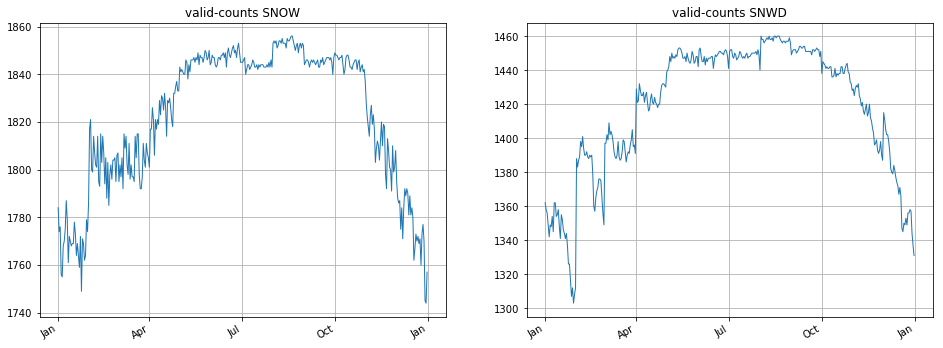

In [8]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [9]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    # in the readme file from downloads, these three measurements are represented as tenths of degrees and tenths of mm.
    if m == 'TMIN' or m == 'TMAX' or m == 'PRCP':
        mean = mean/10
        std = std/10
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    if m == 'TMIN' or m == 'TMAX' or m == 'TOBS':
        axis.set_ylabel('Degree Celsius')
    else:
        axis.set_ylabel('Millimeter')
    YP.plot(graphs,fig,axis,labels = ['mean-std', 'mean', 'mean+std'], title='Mean+-std   '+m)
    
def plot_mean_bar(m,fig,axis, labels=None):
    mean=STAT[m]['Mean']
    # in the readme file from downloads, these three measurements are represented as tenths of degrees and tenths of mm.
    if m == 'TMIN' or m == 'TMAX' or m == 'PRCP':
        mean = mean/10
    
    if m == 'TMIN' or m == 'TMAX' or m == 'TOBS':
        axis.set_ylabel('Degree Celsius')
    else:
        axis.set_ylabel('Millimeter')
    graphs=np.vstack([mean]).transpose()
    YP.bar(graphs,fig,axis, title='Mean+-std   '+m)

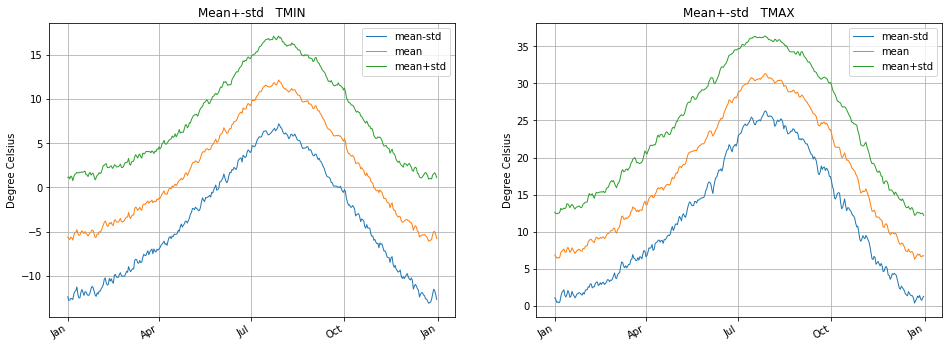

In [10]:
plot_pair(['TMIN','TMAX'],plot_mean_std)
savefig('my_figures/tmin_tmax.png')

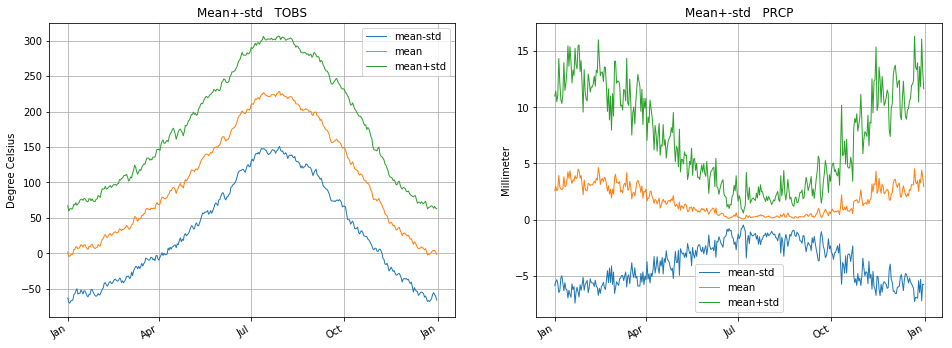

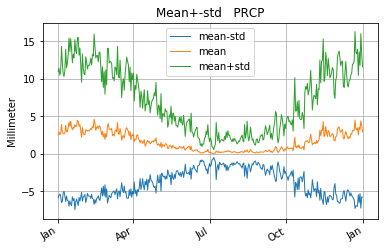

In [11]:
plot_pair(['TOBS','PRCP'],plot_mean_std)
fig_prcp, axis_prcp = subplots()
plot_mean_std('PRCP', fig_prcp, axis_prcp)
savefig('my_figures/prcp_mean_std.png')

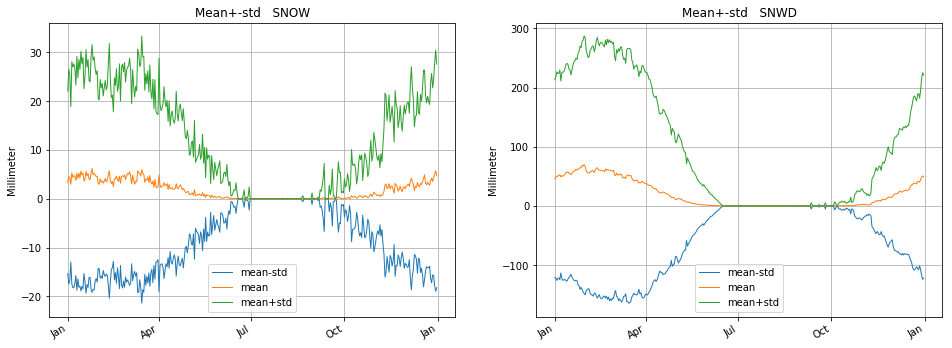

In [12]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)
savefig('my_figures/SNOW_SNWD.png')

### Compare with reference

In [13]:
print "average daily rain fall is %gmm"%np.mean(STAT['PRCP']['mean']/10)
print "average daily snow fall is %gcm"%np.mean(STAT['SNOW']['mean']/10)
print "average monthly rain fall is %gmm"%np.mean(STAT['PRCP']['mean']/10*30)
print "average monthly snow fall is %gcm"%np.mean(STAT['SNOW']['mean']/10*30)
print "average yearly rain fall is %gmm"%np.mean(STAT['PRCP']['mean']/10*365)
print "average yearly snow fall is %gcm"%np.mean(STAT['SNOW']['mean']/10*365)


#Online source http://www.usclimatedata.com/climate/boston/massachusetts/united-states/usma0046/2017/1
average_prcp_slt = [220, 208, 171, 115, 68, 39, 11, 17, 39, 90, 150, 204]
print 'average monthly precipitation in south lake tahoe:%gmm'%(sum(average_prcp_slt)/12)
average_snow_slt = [185.4, 190.5, 215.9, 91.4, 22.9, 5.1, 0, 0, 10.2, 33, 127, 154.9]
print 'average monthly snowfall in boston:%gcm'%(sum(average_snow_slt)/12)

average_prcp_minden = [37, 29, 28, 12, 12, 10, 6, 8, 9, 17, 23, 35]
print 'average monthly precipitation in Minden:%gmm'%(sum(average_prcp_minden)/12)
average_snow_minden = [10.2, 7.6, 5.1, 5.1, 0, 0, 0, 0, 0, 0, 2.5, 12.7]
print 'average monthly snowfall in Minden:%gcm'%(sum(average_snow_minden)/12)

def plot_bar_month(monthly_avg, ylabel, title):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    y_pos = np.arange(len(monthly_avg))
    plt.bar(y_pos, monthly_avg, align='center')
    plt.xticks(y_pos, months)
    plt.ylabel(ylabel)
    plt.title(title)
    
# save figures for references.
plot_bar_month(average_snow_slt, 'Average nowfall (cm)', 'Average snowfall in cm - South Lake Tahoe, NV')
savefig('my_figures/reference_snow_slt.png')
plt.clf()
plot_bar_month(average_snow_minden, 'Average nowfall (cm)', 'Average snowfall in cm - Minden, CA')
savefig('my_figures/reference_snow_minden.png')
plt.clf()

average daily rain fall is 1.66147mm
average daily snow fall is 0.176845cm
average monthly rain fall is 49.844mm
average monthly snow fall is 5.30536cm
average yearly rain fall is 606.435mm
average yearly snow fall is 64.5485cm
average monthly precipitation in south lake tahoe:111mm
average monthly snowfall in boston:86.3583cm
average monthly precipitation in Minden:18mm
average monthly snowfall in Minden:3.6cm


### plotting top 3 eigenvectors

In [14]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

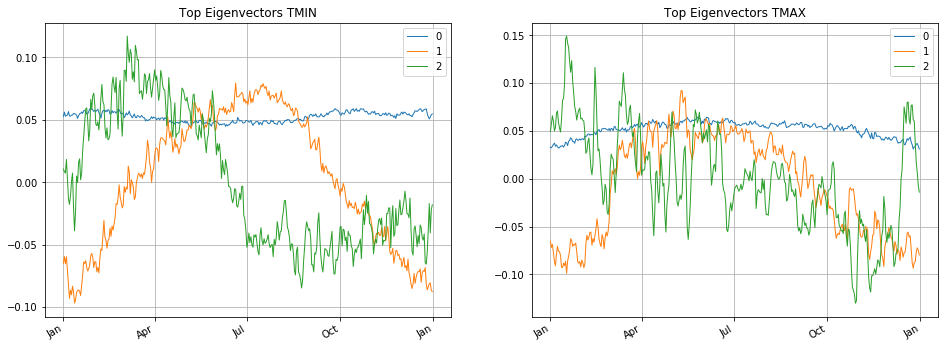

In [15]:
plot_pair(['TMIN','TMAX'],plot_eigen)

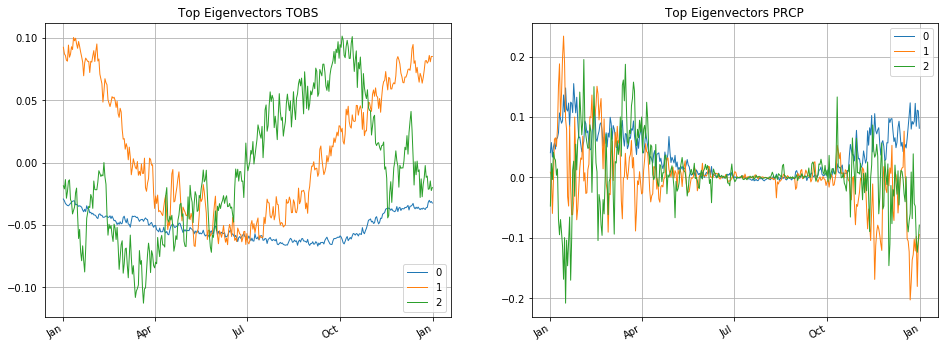

In [16]:
plot_pair(['TOBS','PRCP'],plot_eigen)

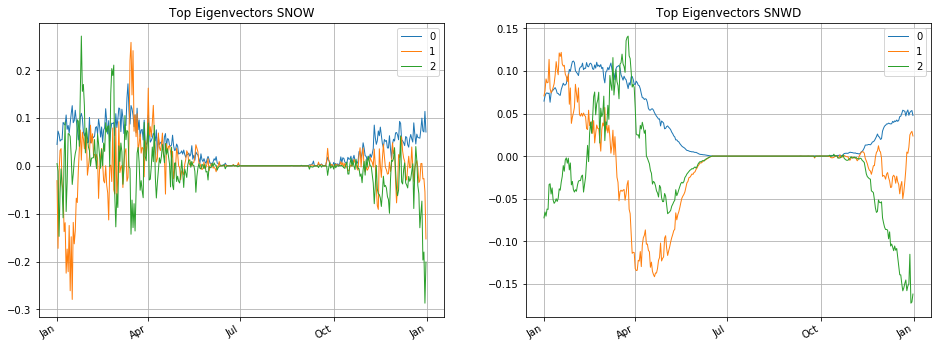

In [17]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [18]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

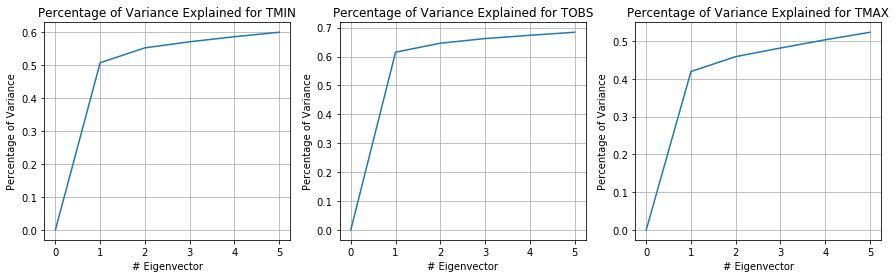

In [19]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
savefig('my_figures/TMIN_TOBS_TMAX.png')

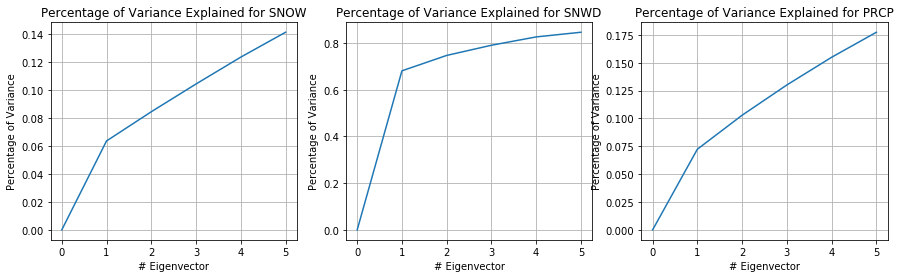

In [20]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 
savefig('my_figures/SNOW_SNWD_PRCP.png')

In [21]:
#sc.stop()

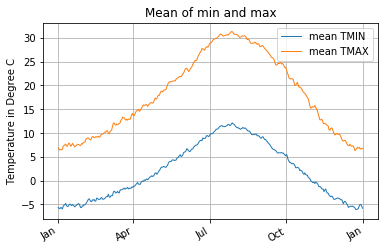

In [22]:
tmin = STAT['TMIN']['Mean']/10
tmax = STAT['TMAX']['Mean']/10
prcp = STAT['PRCP']['Mean']/10
graphs=np.vstack([tmin,tmax]).transpose()
fig,axis=subplots()
axis.set_ylabel('Temperature in Degree C')
YP.plot(graphs,fig,axis,labels=['mean TMIN', 'mean TMAX'], title='Mean of min and max')

savefig('my_figures/average_TMIN_TMAX.png')